# MIMIC IV Sepsis Data Extraction

## import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

##Read in the csv data sheet

In [ ]:
current_dir = os.getcwd()
print(current_dir)
# for patient gender and age
path_patients = current_dir + "/core/patients.csv"
# for diseases diagnosis
path_diagnoses = current_dir + "/hosp/diagnoses_icd.csv"
path_d_diagnoses = current_dir + "/hosp/d_icd_diagnoses.csv"
# for icu stays and extraction of vitals signs
path_d_items = current_dir + "/icu/d_items.csv"
path_icustays = current_dir + "/icu/icustays.csv"
path_chartevents = current_dir + '/icu/chartevents.csv'
path_procedureevents = current_dir + '/icu/procedureevents.csv' # for the patientweight if necessary

/media/hal9001/SSD/Jinyi/physionet.org/files/mimiciv/1.0


In [ ]:
patients = pd.read_csv(path_patients, sep = ',')
diagnoses = pd.read_csv(path_diagnoses, sep = ',')
d_diagnoses = pd.read_csv(path_d_diagnoses, sep = ',')
d_items = pd.read_csv(path_d_items, sep = ',')
icustays = pd.read_csv(path_icustays, sep = ',')
# The read of chartevents will be processed by chunks in Link Function 3
chartevents = pd.read_csv(path_chartevents, sep = ',', nrows = 10) # This is just to read the columns name

In [ ]:
# import csv
# with open(path_chartevents, newline='') as csvfile:
#     row_count = sum(1 for row in csvfile) 

# print('chartevents.csv has {} rows of recordings'.format(row_count))


In [ ]:
# Function: to get the neonatal pateints out of patients.csv
# Input: the patients.csv
# Output: the neonates.csv
def filter_neonate(patients):
    df = patients
    df = df[df['anchor_age'].astype(str).str.fullmatch('0')]
    
    return df

neonates = filter_neonate(patients)
neonates.to_csv(current_dir+"/core/neonates.csv", index = False)
neonates
    

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
1,10002723,F,0,2128,2017 - 2019,NaN
2,10003939,M,0,2184,2008 - 2010,NaN
3,10004222,M,0,2161,2014 - 2016,NaN
4,10005325,F,0,2154,2011 - 2013,NaN
5,10007338,F,0,2153,2017 - 2019,NaN
...,...,...,...,...,...,...
342771,19990875,F,0,2189,2017 - 2019,NaN
342772,19992936,M,0,2126,2008 - 2010,NaN
342773,19994835,M,0,2149,2017 - 2019,NaN
342775,19995611,M,0,2168,2011 - 2013,NaN


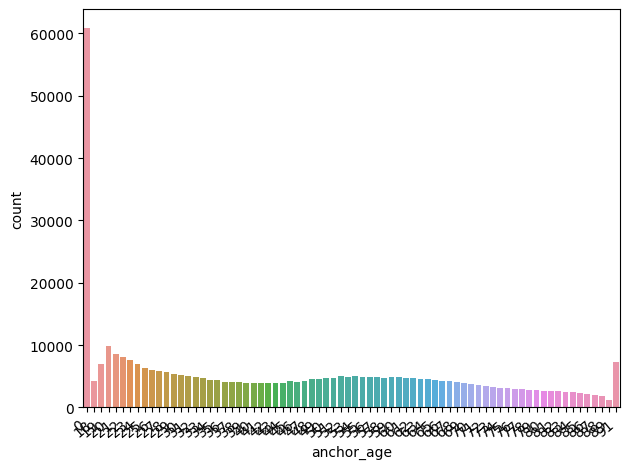

In [ ]:
ax = sns.countplot(x=patients["anchor_age"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Link function 1 -> based on patient ID to fetch gender and age from patients.csv
# Input: subject_id from icustays 
# Output: gender and age with 1 as male and 0 as female
def get_gender_age(subject_id):
    df = patients
    subject_id = str(subject_id)
    df = df[df['subject_id'].astype(str).str.fullmatch(subject_id)]
    gender = df['gender'].values[0]
    if gender == 'F':
        gender = 1
    else:
        gender = 0
    age = df['anchor_age'].values[0]
    
    return gender, age
    
    

In [ ]:
# Link function 2 -> based on patient ID and admission ID to fetch diagnoses result
# Input: subject_id, hadm_id from icustays 
# Output: diagnoses as a list
def get_diagnoses(subject_id, hadm_id):
    diagnoses_names=[]
    
    subject_id = str(subject_id)
    hadm_id = str(hadm_id)
    # first to get the icd_code and icd_version from the dignoses.csv
    df = diagnoses
    df = df[df['subject_id'].astype(str).str.fullmatch(subject_id)]
    df.reset_index(inplace = True, drop = True)
    df = df[df['hadm_id'].astype(str).str.fullmatch(hadm_id)]
    df.reset_index(inplace = True, drop = True)
    df = df.sort_values(by = ['seq_num']).reset_index(drop = True)
    
    # get the disease from the icd code
    for index, row in df.iterrows():
        d_df = d_diagnoses
        icd_code = str(row['icd_code'])
        icd_version = str(row['icd_version'])
        d_df = d_df[d_df['icd_code'].astype(str).str.fullmatch(icd_code)]
        d_df = d_df[d_df['icd_version'].astype(str).str.fullmatch(icd_version)]
        diagnoses_name = d_df['long_title'].values[0]
        diagnoses_names.append(diagnoses_name) # the append here is for list
    
    return diagnoses_names

In [ ]:
# Link function 3 -> based on patient ID, icu stay and admission to fetch vital signs from chartevent
# Input: subject_id, hadm_id, stay_id from icustays 
# Output: a df that contians event_label, value, valueuom, and charttime
def get_events(subject_id, hadm_id, stay_id):
    subject_id = str(subject_id)
    hadm_id = str(hadm_id)
    stay_id = str(stay_id)
    # filter out the events for sepcific IDs
    filtered_events = pd.DataFrame(columns = chartevents.columns)
    i = 1
    for chunk in pd.read_csv(path_chartevents,chunksize = 10000000):
        print('Looping the {}th chunk of total 33 chunks in chartevents.csv'.format(i))
        i+=1
        df = chunk
        df = df[df['subject_id'].astype(str).str.fullmatch(subject_id)]
        df = df[df['hadm_id'].astype(str).str.fullmatch(hadm_id)]
        df = df[df['stay_id'].astype(str).str.fullmatch(stay_id)]
        filtered_events = filtered_events.append(df ,ignore_index=True)
    
    output_events = pd.DataFrame(columns=['abbr','label', 'value','unit','time'])
    
    for index, row in filtered_events.iterrows():
        df_item = d_items
        time = row['charttime']
        value = row['value']
        unit = row['valueuom']
        itemid = str(row['itemid'])
        df_item = df_item[df_item['itemid'].astype(str).str.fullmatch(itemid)]
        abbr = df_item['abbreviation'].values[0]
        label = df_item['label'].values[0]
        new_row = {'abbr':abbr, 'label':label, 'value':value, 'unit':unit, 'time':time}
        output_events = output_events.append(new_row, ignore_index = True)
    
    return output_events
    

In [ ]:
# Filter function: after getting the event table, filter the table to only keep the necessary features
# Input: events as DataFrame, sequence of feature names
# Output: a DataFrame that contains the features from the sequence
def filter_features(df_events, feature_sequence):
    df_filtered = df_events[df_events['abbr'].isin(feature_sequence)]

    return df_filtered


In [ ]:
# Function: to perforrm OR operation considering NaN
def f_or(a,b):
    if not np.isnan(a):
        return a
    if not np.isnan(b):
        return b
    return np.nan

In [ ]:
# Function: re-arranege the dataset according to the timepoints
# Input: the filtered the DataFrame
# Outout: the re-arranged DataFrame

# all_columns_original = ['sepsis','subject_id', 'gender', 'age','los',
#                 'NBPs','NBPd','NBPm','Temperature F','HR','RR','Arterial Base Excess',
#                 'FiO2','SpO2','PCO2 (Arterial)','PH (Arterial)','Magnesium',
#                 'Ionized Calcium','Lactic Acid','Sodium (serum)','Potassium (serum)',
#                 'Creatinine (serum)','Chloride (serum)','HCO3 (serum)','Glucose (serum)',
#                 'WBC','BUN','PTT','Platelet Count','time']

def arrange_time(df_static,df_events, all_columns):
    df_final = pd.DataFrame(columns=all_columns)
    # read the static data
    sepsis = df_static.sepsis[0]
    subject_id = df_static.subject_id[0]
    gender = df_static.gender[0]
    age = df_static.age[0]
    los = df_static.los[0]
    # Get the time points from events
    time_sequence = df_events.loc[:,"time"]
    time_sequence.drop_duplicates( keep='first',inplace= True)
    time_sequence = time_sequence.reset_index(drop =True)
    len_time = len(time_sequence)
    for index_time, value in time_sequence.items():
        time = value
        df_current = df_events
        df_current = df_current[df_current['time'].astype(str).str.fullmatch(time)]
        print('Aviliable DataFrame at this time point',df_current)
        # iterrate each row and set values
        NBPs_final = np.nan
        NBPd_final = np.nan
        NBPm_final = np.nan
        temp_final = np.nan
        hr_final = np.nan
        rr_final = np.nan
        abe_final = np.nan
        FiO2_final = np.nan
        SpO2_final = np.nan
        PCO2_final = np.nan
        ph_final = np.nan
        magnesium_final = np.nan
        calcium_final = np.nan
        latic_final  = np.nan
        sodium_final = np.nan
        potassium_final = np.nan
        creatinine_final = np.nan
        chloride_final = np.nan
        HCO3_final = np.nan
        glucose_final = np.nan
        WBC_final = np.nan
        BUN_final = np.nan
        PTT_final = np.nan
        platelet_final = np.nan
        for index, row in df_current.iterrows():
            if row['abbr'] == 'NBPs':
                NBPs = row['value']
            else: NBPs = np.nan
            NBPs_final = f_or(NBPs_final,NBPs)
            
            if row['abbr'] == 'NBPd':
                NBPd = row['value']
            else: NBPd = np.nan
            NBPd_final = f_or(NBPd_final,NBPd)
            
            if row['abbr'] == 'NBPm':
                NBPm = row['value']
            else: NBPm = np.nan
            NBPm_final = f_or(NBPm_final,NBPm)
            
            if row['abbr'] == 'Temperature F':
                temp = row['value']
            else: temp = np.nan
            temp_final = f_or(temp_final,temp)
            
            if row['abbr'] == 'HR':
                hr = row['value']
            else: hr = np.nan
            hr_final = f_or(hr_final,hr)
            
            if row['abbr'] == 'RR':
                rr = row['value']
            else: rr = np.nan
            rr_final = f_or(rr_final,rr)
            
            if row['abbr'] == 'Arterial Base Excess':
                abe = row['value']
            else: abe = np.nan
            abe_final = f_or(abe_final,abe)
            
            if row['abbr'] == 'FiO2':
                FiO2 = row['value']
            else: FiO2 = np.nan
            FiO2_final = f_or(FiO2_final,FiO2)

            if row['abbr'] == 'SpO2':
                SpO2 = row['value']
            else: SpO2 = np.nan
            SpO2_final = f_or(SpO2_final,SpO2)
            
            if row['abbr'] == 'PCO2 (Arterial)':
                PCO2 = row['value']
            else: PCO2 = np.nan
            PCO2_final = f_or(PCO2_final,PCO2)
            
            if row['abbr'] == 'PH (Arterial)':
                ph = row['value']
            else: ph = np.nan
            ph_final = f_or(ph_final,ph)
            
            if row['abbr'] == 'Magnesium':
                magnesium = row['value']
            else: magnesium = np.nan
            magnesium_final = f_or(magnesium_final,magnesium)
            
            if row['abbr'] == 'Ionized Calcium':
                calcium = row['value']
            else: calcium = np.nan
            calcium_final = f_or(calcium_final,calcium)
            
            if row['abbr'] == 'Lactic Acid':
                latic = row['value']
            else: latic = np.nan
            latic_final = f_or(latic_final,latic)
            
            if row['abbr'] == 'Sodium (serum)':
                sodium = row['value']
            else: sodium = np.nan
            sodium_final = f_or(sodium_final,sodium)
            
            if row['abbr'] == 'Potassium (serum)':
                potassium = row['value']
            else: potassium = np.nan
            potassium_final = f_or(potassium_final,potassium)
            
            if row['abbr'] == 'Creatinine (serum)':
                creatinine = row['value']
            else: creatinine = np.nan
            creatinine_final = f_or(creatinine_final,creatinine)
            
            if row['abbr'] == 'Chloride (serum)':
                chloride = row['value']
            else: chloride = np.nan
            chloride_final = f_or(chloride_final,chloride)
            
            if row['abbr'] == 'HCO3 (serum)':
                HCO3 = row['value']
            else: HCO3 = np.nan
            HCO3_final = f_or(HCO3_final,HCO3)
            
            if row['abbr'] == 'Glucose (serum)':
                glucose = row['value']
            else: glucose = np.nan
            glucose_final = f_or(glucose_final,glucose)
            
            if row['abbr'] == 'WBC':
                WBC = row['value']
            else: WBC = np.nan
            WBC_final = f_or(WBC_final,WBC)
            
            if row['abbr'] == 'BUN':
                BUN = row['value']
            else: BUN = np.nan
            BUN_final = f_or(BUN_final,BUN)
            
            if row['abbr'] == 'PTT':
                PTT = row['value']
            else: PTT = np.nan
            PTT_final = f_or(PTT_final,PTT)
            
            if row['abbr'] == 'Platelet Count':
                platelet = row['value']
            else: platelet = np.nan
            platelet_final = f_or(platelet_final,platelet)

        new_row={'sepsis':sepsis,'subject_id':subject_id, 'gender':gender, 'age':age,'los':los,
                'SBP':NBPs_final,'DBP':NBPd_final,'MAP':NBPm_final,'Temp':temp_final,'HR':hr_final,'Resp':rr_final,'BaseExcess':abe_final,
                'FiO2':FiO2_final,'O2Sat':SpO2_final,'PaCO2':PCO2_final,'pH':ph_final,'Magnesium':magnesium_final,
                'Calcium':calcium_final,'Lactate':latic_final,'Sodium':sodium_final,'Potassium':potassium_final,
                'Creatinine':creatinine_final,'Chloride':chloride_final,'HCO3':HCO3_final,'Glucose':glucose_final,
                'WBC':WBC_final,'BUN':BUN_final,'PTT': PTT_final,'Platelets':platelet_final,'time':time}
        print('The new row:',new_row)
        df_final = df_final.append(new_row,ignore_index = True)

    return df_final
    

In [ ]:
# Main
feature_sequence = ['NBPs','NBPd','NBPm','Temperature F','HR','RR','Arterial Base Excess',
                    'FiO2','SpO2','PCO2 (Arterial)','PH (Arterial)','Magnesium',
                    'Ionized Calcium','Lactic Acid','Sodium (serum)','Potassium (serum)',
                    'Creatinine (serum)','Chloride (serum)','HCO3 (serum)','Glucose (serum)',
                    'WBC','BUN','PTT','Platelet Count']

all_columns = ['sepsis','subject_id', 'gender', 'age','los',
                'SBP','DBP','MAP','Temp','HR','Resp','BaseExcess',
                'FiO2','O2Sat','PaCO2','pH','Magnesium',
                'Calcium','Lactate','Sodium','Potassium',
                'Creatinine','Chloride','HCO3','Glucose',
                'WBC','BUN','PTT','Platelets','time']   # the features from events are renamed

i = 1

for index, row in icustays.iterrows():
    print('-----------Processing the {}th entry-----------'.format(i))
    i+=1
    d_diagnoses = pd.read_csv(path_d_diagnoses, sep = ',')
    diagnoses = pd.read_csv(path_diagnoses, sep = ',')

    subject_id = row['subject_id']
    hadm_id = row['hadm_id']
    stay_id = row['stay_id']
    los = row['los']
    # get the diagnoses
    sepsis_detect = ['sepsis','septic','Sepsis','Septic']
    diagnoses = get_diagnoses(subject_id, hadm_id)
    diagnoses_label = any(s in d for s in sepsis_detect for d in diagnoses) # True or False
    
    # to generate the static dataset
    static_info = pd.DataFrame(columns = ['sepsis','subject_id','gender','age','los'])
    gender, age = get_gender_age(subject_id)
    new_static_row = {'sepsis':diagnoses_label,'subject_id': subject_id,'gender': gender,'age': age,'los': los}
    static_info=static_info.append(new_static_row, ignore_index = True)
    
    # to generate the event dataset
    events_info = get_events(subject_id, hadm_id, stay_id)
    filtered_info = filter_features(events_info,feature_sequence)

    # to generate the datasheet in one table
    all_info = arrange_time(static_info,filtered_info,all_columns)


    if age == 0:
        static_info.to_csv(current_dir+'/neonates/'+str(subject_id)+str(stay_id)+'.csv', index = False)
        filtered_info.to_csv(current_dir+'/neonates/'+str(subject_id)+str(stay_id)+'_events.csv', index = False)
        all_info.to_csv(current_dir+'/neonates_one/'+str(subject_id)+str(stay_id)+'.csv', index = False)
    else:
        static_info.to_csv(current_dir+'/adults/'+str(subject_id)+str(stay_id)+'.csv', index = False)
        filtered_info.to_csv(current_dir+'/adults/'+str(subject_id)+str(stay_id)+'_events.csv', index = False)
        all_info.to_csv(current_dir+'/adults_one/'+str(subject_id)+str(stay_id)+'.csv', index = False)

-----------Processing the 1th entry-----------


/tmp/ipykernel_3567/3569771043.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_info=static_info.append(new_static_row, ignore_index = True)


Static Info:   sepsis subject_id gender age       los
0  False   17867402      0  25  1.587454
-----------Processing the 2th entry-----------


/tmp/ipykernel_3567/3569771043.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_info=static_info.append(new_static_row, ignore_index = True)


Static Info:   sepsis subject_id gender age       los
0  False   14435996      0  42  3.025625
-----------Processing the 3th entry-----------


/tmp/ipykernel_3567/3569771043.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_info=static_info.append(new_static_row, ignore_index = True)


Static Info:   sepsis subject_id gender age       los
0   True   17609946      0  70  9.741725
-----------Processing the 4th entry-----------


/tmp/ipykernel_3567/3569771043.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_info=static_info.append(new_static_row, ignore_index = True)


Static Info:   sepsis subject_id gender age       los
0  False   18966770      0  87  0.350544
-----------Processing the 5th entry-----------


/tmp/ipykernel_3567/3569771043.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_info=static_info.append(new_static_row, ignore_index = True)


Static Info:   sepsis subject_id gender age       los
0  False   12776735      0  72  1.674769
-----------Processing the 6th entry-----------


/tmp/ipykernel_3567/3569771043.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_info=static_info.append(new_static_row, ignore_index = True)


Static Info:   sepsis subject_id gender age       los
0  False   10215159      1  67  1.292697
-----------Processing the 7th entry-----------


/tmp/ipykernel_3567/3569771043.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_info=static_info.append(new_static_row, ignore_index = True)


Static Info:   sepsis subject_id gender age       los
0  False   14489052      1  74  0.412662
-----------Processing the 8th entry-----------


/tmp/ipykernel_3567/3569771043.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_info=static_info.append(new_static_row, ignore_index = True)


Static Info:   sepsis subject_id gender age       los
0  False   15914763      0  51  2.990984
-----------Processing the 9th entry-----------


KeyboardInterrupt: 

In [ ]:
icustays_count = icustays.groupby(['subject_id'])['subject_id'].count()
print (type(icustays_count))
print (icustays_count[icustays_count > 1])